## Music genre classifier with TensorFlow

To classify audio samples, we will preprocess them by calculating their MFCC, which is a temporal representation of the energy for each perceived frequency band. In this case, we are choosing 13 bands.

In [ ]:
%pip install tensorflow

# I already had sklearn idk why or how
%pip install sklearn

In [1]:
import os
import json
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [15]:
SOURCE_PATH = '../Data/genres_original/'

# Path to labels and processed data file, json format.
JSON_PATH = 'self/data.json'

# Sampling rate.
sr = 22050

# Let's make sure all files have the same amount of samples and pick a duration right under 30 seconds.
TOTAL_SAMPLES = 29 * sr

'''
    The dataset contains 999 files.
    But I want more so we will slice the dataset, so we get more data entries.
    which should give me a better result? hummmm... Hopefully ... i think so ... maybe ..
    X amount of slices => X times more training examples.
'''
NUM_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

In [12]:
def preprocess_data(source_path, json_path):

    # create a dictionary of labels and processed data.
    mydict = {
        "labels": [],
        "mfcc": []
        }

    # browse each file, slice it and generate the 13 band mfcc for each slice.
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):
        for file in filenames:
            # exclude a corrupted wav file that makes everything crash.
            if os.path.join(dirpath, file) != '../Data/genres_original/jazz\\jazz.00054.wav' or file != 'jazz.00054.wav':
                song, sr = librosa.load(os.path.join(dirpath, file), duration=29)
                
                # re-sample the song to 22050 Hz. its not mandatory but it's better for the model in general.
                for s in range(NUM_SLICES):
                    start_sample = SAMPLES_PER_SLICE * s
                    end_sample = start_sample + SAMPLES_PER_SLICE
                    mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
                    mfcc = mfcc.T
                    mydict["labels"].append(i-1)
                    mydict["mfcc"].append(mfcc.tolist())
            else:
                pass

    # write the dictionary in the json file.    
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

In [4]:
def load_data(json_path):

    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()

    # load our data into numpy arrays for TensorFlow compatibility.
    # not going to lie did try using other arrays but it crashed and had to figure out why.
    X = np.array(data["mfcc"])
    Y = np.array(data["labels"])

    return X, Y

In [5]:
def prepare_datasets(inputs, targets, split_size):
    # Creating a validation set and a test set.
    inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=split_size)
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs_train, targets_train, test_size=split_size)
    
    # Our CNN model expects 3D input shape.
    inputs_train = inputs_train[..., np.newaxis]
    inputs_val = inputs_val[..., np.newaxis]
    inputs_test = inputs_test[..., np.newaxis]
    
    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test

In [6]:
'''
    Still don't know how to use the tensorflow abi in general.
'''

def design_model(input_shape):

    # Let's design the model architecture.
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

In [7]:
def make_prediction(model, X, y, idx):
    genre_dict = {
        0 : "blues",
        1 : "classical",
        2 : "country",
        3 : "disco",
        4 : "hiphop",
        5 : "jazz",
        6 : "metal",
        7 : "pop",
        8 : "reggae",
        9 : "rock",
        }
        
    predictions = model.predict(X)
    genre = np.argmax(predictions[idx])
    
    print("\n---Now testing the model for one audio file")
    print("\n---The model predicts: {}, and ground truth is: {}.\n".format(genre_dict[genre], genre_dict[y[idx]]))

In [8]:
# function that shows the model's accuracy in a GRAPH.
def plot_performance(hist):
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 123, 11, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 6, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 62, 6, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 4, 32)         9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 2, 32)        0         
 2D)                                                             
                                                      

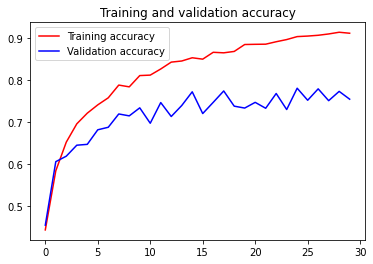

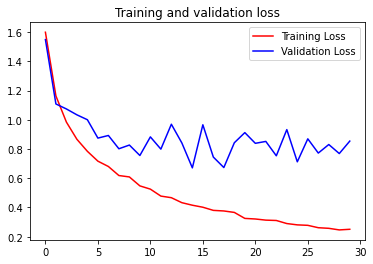


---Now testing the model for one audio file

---The model predicts: reggae, and ground truth is: reggae.



In [17]:
if __name__ == "__main__":

    # preprocess the data.    
    preprocess_data(source_path=SOURCE_PATH, json_path=JSON_PATH)
    
    # load the data.
    inputs, targets = load_data(json_path=JSON_PATH)
    
    # split the data into training, validation and test sets
    # data preparation simple as that.
    xtrain, xval, xtest, ytrain, yval, ytest = prepare_datasets(inputs, targets, 0.2)

    # design the model.
    input_shape = (xtrain.shape[1], xtrain.shape[2], 1)
    model = design_model(input_shape)

    # Selection of the optimizer, loss type and metrics for performance evaluation.
    # still don't really know what it's doing.
    model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics = ['acc'])

    model.summary()

    # Training the model. Play Rocky Music.
    history = model.fit(xtrain, ytrain,
                        validation_data=(xval, yval),
                        epochs=30,
                        batch_size=32)

    # we gonna see if the performance is good.
    plot_performance(history)

    # Testing the model on never seen before data.
    make_prediction(model, xtest, ytest, 24)